# Generative Adversarial Nerwork - AnimeGAN

Outline

1.   Initialize weights 
2.   Establish Five Component Blocks of the Generator Network  
3.   Generator Network
4.   Discriminator Network
5.   Initialize Overall Network Settings
6.   Prepare VGG19
7.   Initialize Loss Functions
8.   Helper Function
9.   Prepare Dataset
10.  Prepare Colab Path
11.  Initialize the Generator and Discriminator
12.  Show Summarize of the Network Structure
13.  Main - Training
14.  References


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import cv2
from tqdm import tqdm
import numpy as np

# Imports for the helper functions
import gc
import urllib.request

# Imports for the generator and discriminator
from torch.nn.utils import spectral_norm

# Imports for main training
import torch.optim as optim
from multiprocessing import cpu_count
from torch.utils.data import DataLoader

#Imports for Prepare Dataset
import pandas as pd
from torch.utils.data import Dataset

### 1. Initialize weights

In [2]:
# Initilize weights

def initialize_weights(net):
    for m in net.modules():
        try:
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        except Exception as e:
            # print(f'SKip layer {m}, {e}')
            pass

### 2. Five Component Blocks of the Generator Network

In [3]:
# 5 Component Blocks of the Generator Network

class DownConv(nn.Module):
    def __init__(self, channels, bias=False):
        super(DownConv, self).__init__()
        self.conv1 = SeparableConv2D(channels, channels, stride=2, bias=bias)
        self.conv2 = SeparableConv2D(channels, channels, stride=1, bias=bias)

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = F.interpolate(x, scale_factor=0.5, mode='bilinear')
        out2 = self.conv2(out2)

        return out1 + out2


class UpConv(nn.Module):
    def __init__(self, channels, bias=False):
        super(UpConv, self).__init__()
        self.conv = SeparableConv2D(channels, channels, stride=1, bias=bias)

    def forward(self, x):
        out = F.interpolate(x, scale_factor=2.0, mode='bilinear')
        out = self.conv(out)

        return out


class SeparableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, bias=False):
        super(SeparableConv2D, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3,
            stride=stride, padding=1, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels,
            kernel_size=1, stride=1, bias=bias)
        # self.pad = 
        self.ins_norm1 = nn.InstanceNorm2d(in_channels)
        self.activation1 = nn.LeakyReLU(0.2, True)
        self.ins_norm2 = nn.InstanceNorm2d(out_channels)
        self.activation2 = nn.LeakyReLU(0.2, True)

        initialize_weights(self)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.ins_norm1(out)
        out = self.activation1(out)

        out = self.pointwise(out)
        out = self.ins_norm2(out)

        return self.activation2(out)


class ConvBlock(nn.Module):
    def __init__(self, channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(channels, out_channels,
            kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.ins_norm = nn.InstanceNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2, True)

        initialize_weights(self)

    def forward(self, x):
        out = self.conv(x)
        out = self.ins_norm(out)
        out = self.activation(out)

        return out


class InvertedResBlock(nn.Module):
    def __init__(self, channels=256, out_channels=256, expand_ratio=2, bias=False):
        super(InvertedResBlock, self).__init__()
        bottleneck_dim = round(expand_ratio * channels)
        self.conv_block = ConvBlock(channels, bottleneck_dim, kernel_size=1, stride=1, padding=0, bias=bias)
        self.depthwise_conv = nn.Conv2d(bottleneck_dim, bottleneck_dim,
            kernel_size=3, groups=bottleneck_dim, stride=1, padding=1, bias=bias)
        self.conv = nn.Conv2d(bottleneck_dim, out_channels,
            kernel_size=1, stride=1, bias=bias)

        self.ins_norm1 = nn.InstanceNorm2d(out_channels)
        self.ins_norm2 = nn.InstanceNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2, True)

        initialize_weights(self)

    def forward(self, x):
        out = self.conv_block(x)
        out = self.depthwise_conv(out)
        out = self.ins_norm1(out)
        out = self.activation(out)
        out = self.conv(out)
        out = self.ins_norm2(out)

        return out + x

### 3. Generator Network

In [4]:
# The Generator Network

class Generator(nn.Module):
    def __init__(self, dataset=''):
        super(Generator, self).__init__()
        self.name = f'generator_{dataset}'
        bias = False

        self.encode_blocks = nn.Sequential(
            ConvBlock(3, 64, bias=bias),
            ConvBlock(64, 128, bias=bias),
            DownConv(128, bias=bias),
            ConvBlock(128, 128, bias=bias),
            SeparableConv2D(128, 256, bias=bias),
            DownConv(256, bias=bias),
            ConvBlock(256, 256, bias=bias),
        )

        self.res_blocks = nn.Sequential(
            InvertedResBlock(256, 256, bias=bias),
            InvertedResBlock(256, 256, bias=bias),
            InvertedResBlock(256, 256, bias=bias),
            InvertedResBlock(256, 256, bias=bias),
            InvertedResBlock(256, 256, bias=bias),
            InvertedResBlock(256, 256, bias=bias),
            InvertedResBlock(256, 256, bias=bias),
            InvertedResBlock(256, 256, bias=bias),
        )

        self.decode_blocks = nn.Sequential(
            ConvBlock(256, 128, bias=bias),
            UpConv(128, bias=bias),
            SeparableConv2D(128, 128, bias=bias),
            ConvBlock(128, 128, bias=bias),
            UpConv(128, bias=bias),
            ConvBlock(128, 64, bias=bias),
            ConvBlock(64, 64, bias=bias),
            nn.Conv2d(64, 3, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.Tanh(),
        )

        initialize_weights(self)

    def forward(self, x):
        out = self.encode_blocks(x)
        out = self.res_blocks(out)
        img = self.decode_blocks(out)

        return img

### 4. Discriminator Network

In [5]:
# The Discriminator Network

class Discriminator(nn.Module):
    def __init__(self,  args):
        super(Discriminator, self).__init__()
        self.name = f'discriminator_{args.dataset}'
        self.bias = False
        channels = 32

        layers = [
            nn.Conv2d(3, channels, kernel_size=3, stride=1, padding=1, bias=self.bias),
            nn.LeakyReLU(0.2, True)
        ]

        for i in range(args.d_layers):
            layers += [
                nn.Conv2d(channels, channels * 2, kernel_size=3, stride=2, padding=1, bias=self.bias),
                nn.LeakyReLU(0.2, True),
                nn.Conv2d(channels * 2, channels * 4, kernel_size=3, stride=1, padding=1, bias=self.bias),
                nn.InstanceNorm2d(channels * 4),
                nn.LeakyReLU(0.2, True),
            ]
            channels *= 4

        layers += [
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=self.bias),
            nn.InstanceNorm2d(channels),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(channels, 1, kernel_size=3, stride=1, padding=1, bias=self.bias),
        ]

        if args.use_sn:
            for i in range(len(layers)):
                if isinstance(layers[i], nn.Conv2d):
                    layers[i] = spectral_norm(layers[i])

        self.discriminate = nn.Sequential(*layers)

        initialize_weights(self)

    def forward(self, img):
        return self.discriminate(img)

### 5. Initialize Overall Network Settings

In [6]:
# Initilize model settings

class Setting:
  def __init__(self):
    self.dataset = 'Hayao'
    self.data_dir = '/content/dataset'

    self.epochs = 100
    self.init_epochs = 5
    self.batch_size = 6

    self.checkpoint_dir = '/content/checkpoints'
    self.save_image_dir = '/content/images'
    self.gan_loss = 'lsgan'

    self.resume = 'False'
    self.use_sn = 'False'

    self.save_interval = 1
    self.debug_samples = 0
    self.lr_g = 0.00002
    self.lr_d = 0.00004
    self.init_lr = 0.0001

    self.wadvg = 10.0
    self.wadvd = 10.0
    self.wcon = 1.5
    self.wgra = 3.0
    self.wcol = 70.0
    self.d_layers = 3
    self.d_noise = 'False'

args = Setting()

In [7]:
vars(args)

{'dataset': 'Hayao',
 'data_dir': '/content/dataset',
 'epochs': 100,
 'init_epochs': 5,
 'batch_size': 6,
 'checkpoint_dir': '/content/checkpoints',
 'save_image_dir': '/content/images',
 'gan_loss': 'lsgan',
 'resume': 'False',
 'use_sn': 'False',
 'save_interval': 1,
 'debug_samples': 0,
 'lr_g': 2e-05,
 'lr_d': 4e-05,
 'init_lr': 0.0001,
 'wadvg': 10.0,
 'wadvd': 10.0,
 'wcon': 1.5,
 'wgra': 3.0,
 'wcol': 70.0,
 'd_layers': 3,
 'd_noise': 'False'}

In [8]:
# import torch
# import cv2
# import os
# import numpy as np
# from tqdm import tqdm

_rgb_to_yuv_kernel = torch.tensor([
    [0.299, -0.14714119, 0.61497538],
    [0.587, -0.28886916, -0.51496512],
    [0.114, 0.43601035, -0.10001026]
]).float()

if torch.cuda.is_available():
    _rgb_to_yuv_kernel = _rgb_to_yuv_kernel.cuda()


def gram(input):
    """
    Calculate Gram Matrix
    https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#style-loss
    """
    b, c, w, h = input.size()
    x = input.view(b * c, w * h)
    G = torch.mm(x, x.T)

    # normalize by total elements
    return G.div(b * c * w * h)

def rgb_to_yuv(image):
    '''
    https://en.wikipedia.org/wiki/YUV
    output: Image of shape (H, W, C) (channel last)
    '''
    # -1 1 -> 0 1
    image = (image + 1.0) / 2.0
    yuv_img = torch.tensordot(
        image,
        _rgb_to_yuv_kernel,
        dims=([image.ndim - 3], [0]))

    return yuv_img


def divisible(dim):
    '''
    Make width and height divisible by 32
    '''
    width, height = dim
    return width - (width % 32), height - (height % 32)


def resize_image(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    h, w = image.shape[:2]

    if width and height:
        return cv2.resize(image, divisible((width, height)),  interpolation=inter)

    if width is None and height is None:
        return cv2.resize(image, divisible((w, h)),  interpolation=inter)

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, divisible(dim), interpolation=inter)


def normalize_input(images):
    '''
    [0, 255] -> [-1, 1]
    '''
    return images / 127.5 - 1.0


def denormalize_input(images, dtype=None):
    '''
    [-1, 1] -> [0, 255]
    '''
    images = images * 127.5 + 127.5

    if dtype is not None:
        if isinstance(images, torch.Tensor):
            images = images.type(dtype)
        else:
            # numpy.ndarray
            images = images.astype(dtype)

    return images


def compute_data_mean(data_folder):
    if not os.path.exists(data_folder):
        raise FileNotFoundError(f'Folder {data_folder} does not exits')

    image_files = os.listdir(data_folder)
    total = np.zeros(3)

    print(f"Compute mean (R, G, B) from {len(image_files)} images")

    for img_file in tqdm(image_files):
        path = os.path.join(data_folder, img_file)
        image = cv2.imread(path)
        total += image.mean(axis=(0, 1))

    channel_mean = total / len(image_files)
    mean = np.mean(channel_mean)

    return mean - channel_mean[...,::-1]  # Convert to BGR for training

### 6. Prepare VGG19

In [9]:
from numpy.lib.arraysetops import isin
import torchvision.models as models
# import torch.nn as nn
# import torch

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).float()
vgg_std = torch.tensor([0.229, 0.224, 0.225]).float()

if torch.cuda.is_available():
    vgg_std = vgg_std.cuda()
    vgg_mean = vgg_mean.cuda()

class Vgg19(nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        self.vgg19 = self.get_vgg19().eval()
        self.mean = vgg_mean.view(-1, 1 ,1)
        self.std = vgg_std.view(-1, 1, 1)

    def forward(self, x):
        return self.vgg19(self.normalize_vgg(x))


    @staticmethod
    def get_vgg19(last_layer='conv4_4'):
        vgg = models.vgg19(pretrained=torch.cuda.is_available()).features
        model_list = []

        i = 0
        j = 1
        for layer in vgg.children():
            if isinstance(layer, nn.MaxPool2d):
                i = 0
                j += 1

            elif isinstance(layer, nn.Conv2d):
                i += 1

            name = f'conv{j}_{i}'

            if name == last_layer:
                model_list.append(layer)
                break

            model_list.append(layer)


        model = nn.Sequential(*model_list)
        return model


    def normalize_vgg(self, image):
        '''
        Expect input in range -1 1
        '''
        image = (image + 1.0) / 2.0
        return (image - self.mean) / self.std


### 7.Initialize Loss Functions

In [10]:
class ColorLoss(nn.Module):
    def __init__(self):
        super(ColorLoss, self).__init__()
        self.l1 = nn.L1Loss()
        self.huber = nn.SmoothL1Loss()

    def forward(self, image, image_g):
        image = rgb_to_yuv(image)
        image_g = rgb_to_yuv(image_g)

        return (self.l1(image[:, :, :, 0], image_g[:, :, :, 0]) +
                self.huber(image[:, :, :, 1], image_g[:, :, :, 1]) +
                self.huber(image[:, :, :, 2], image_g[:, :, :, 2]))

In [11]:
class AnimeGanLoss:
    def __init__(self, args):
        self.content_loss = nn.L1Loss().cuda()
        self.gram_loss = nn.L1Loss().cuda()
        self.color_loss = ColorLoss().cuda()
        self.wadvg = args.wadvg
        self.wadvd = args.wadvd
        self.wcon = args.wcon
        self.wgra = args.wgra
        self.wcol = args.wcol
        self.vgg19 = Vgg19().cuda().eval()
        self.adv_type = args.gan_loss
        self.bce_loss = nn.BCELoss()

    def compute_loss_G(self, fake_img, img, fake_logit, anime_gray):
        '''
        Compute loss for Generator

        @Arugments:
            - fake_img: generated image
            - img: image
            - fake_logit: output of Discriminator given fake image
            - anime_gray: grayscale of anime image

        @Returns:
            loss
        '''
        fake_feat = self.vgg19(fake_img)
        anime_feat = self.vgg19(anime_gray)
        img_feat = self.vgg19(img).detach()

        return [
            self.wadvg * self.adv_loss_g(fake_logit),
            self.wcon * self.content_loss(img_feat, fake_feat),
            self.wgra * self.gram_loss(gram(anime_feat), gram(fake_feat)),
            self.wcol * self.color_loss(img, fake_img),
        ]

    def compute_loss_D(self, fake_img_d, real_anime_d, real_anime_gray_d, real_anime_smooth_gray_d):
        return self.wadvd * (
            self.adv_loss_d_real(real_anime_d) +
            self.adv_loss_d_fake(fake_img_d) +
            self.adv_loss_d_fake(real_anime_gray_d) +
            0.2 * self.adv_loss_d_fake(real_anime_smooth_gray_d)
        )


    def content_loss_vgg(self, image, recontruction):
        feat = self.vgg19(image)
        re_feat = self.vgg19(recontruction)

        return self.content_loss(feat, re_feat)

    def adv_loss_d_real(self, pred):
        if self.adv_type == 'hinge':
            return torch.mean(F.relu(1.0 - pred))

        elif self.adv_type == 'lsgan':
            return torch.mean(torch.square(pred - 1.0))

        elif self.adv_type == 'normal':
            return self.bce_loss(pred, torch.ones_like(pred))

        raise ValueError(f'Do not support loss type {self.adv_type}')

    def adv_loss_d_fake(self, pred):
        if self.adv_type == 'hinge':
            return torch.mean(F.relu(1.0 + pred))

        elif self.adv_type == 'lsgan':
            return torch.mean(torch.square(pred))

        elif self.adv_type == 'normal':
            return self.bce_loss(pred, torch.zeros_like(pred))

        raise ValueError(f'Do not support loss type {self.adv_type}')


    def adv_loss_g(self, pred):
        if self.adv_type == 'hinge':
            return -torch.mean(pred)

        elif self.adv_type == 'lsgan':
            return torch.mean(torch.square(pred - 1.0))

        elif self.adv_type == 'normal':
            return self.bce_loss(pred, torch.zeros_like(pred))

        raise ValueError(f'Do not support loss type {self.adv_type}')


In [12]:

class LossSummary:
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss_g_adv = []
        self.loss_content = []
        self.loss_gram = []
        self.loss_color = []
        self.loss_d_adv = []

    def update_loss_G(self, adv, gram, color, content):
        self.loss_g_adv.append(adv.cpu().detach().numpy())
        self.loss_gram.append(gram.cpu().detach().numpy())
        self.loss_color.append(color.cpu().detach().numpy())
        self.loss_content.append(content.cpu().detach().numpy())

    def update_loss_D(self, loss):
        self.loss_d_adv.append(loss.cpu().detach().numpy())

    def avg_loss_G(self):
        return (
            self._avg(self.loss_g_adv),
            self._avg(self.loss_gram),
            self._avg(self.loss_color),
            self._avg(self.loss_content),
        )

    def avg_loss_D(self):
        return self._avg(self.loss_d_adv)


    @staticmethod
    def _avg(losses):
        return sum(losses) / len(losses)

### 8. Helper Functions

In [13]:
import torch
import gc
import os
import torch.nn as nn
import urllib.request
import cv2
from tqdm import tqdm

HTTP_PREFIXES = [
    'http',
    'data:image/jpeg',
]

SUPPORT_WEIGHTS = {
    'hayao',
    'shinkai',
}

ASSET_HOST = 'https://github.com/ptran1203/pytorch-animeGAN/releases/download/v1.0'


def read_image(path):
    """
    Read image from given path
    """

    if any(path.startswith(p) for p in HTTP_PREFIXES):
        urllib.request.urlretrieve(path, "temp.jpg")
        path = "temp.jpg"

    return cv2.imread(path)[: ,: ,::-1]


def save_checkpoint(model, optimizer, epoch, args, posfix=''):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }
    path = os.path.join(args.checkpoint_dir, f'{model.name}{posfix}.pth')
    torch.save(checkpoint, path)


def load_checkpoint(model, checkpoint_dir, posfix=''):
    path = os.path.join(checkpoint_dir, f'{model.name}{posfix}.pth')
    return load_weight(model, path)


def load_weight(model, weight):
    if weight.lower() in SUPPORT_WEIGHTS:
        weight = _download_weight(weight)

    checkpoint = torch.load(weight,  map_location='cuda:0') if torch.cuda.is_available() else \
        torch.load(weight,  map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    epoch = checkpoint['epoch']
    del checkpoint
    torch.cuda.empty_cache()
    gc.collect()

    return epoch


# def initialize_weights(net):
#     for m in net.modules():
#         try:
#             if isinstance(m, nn.Conv2d):
#                 m.weight.data.normal_(0, 0.02)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.ConvTranspose2d):
#                 m.weight.data.normal_(0, 0.02)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.weight.data.normal_(0, 0.02)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#         except Exception as e:
#             # print(f'SKip layer {m}, {e}')
#             pass


def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


class DownloadProgressBar(tqdm):
    '''
    https://stackoverflow.com/questions/15644964/python-progress-bar-and-downloads
    '''
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def _download_weight(weight):
    '''
    Download weight and save to local file
    '''
    filename = f'generator_{weight.lower()}.pth'
    os.makedirs('.cache', exist_ok=True)
    url = f'{ASSET_HOST}/{filename}'
    save_path = f'.cache/{filename}'

    if os.path.isfile(save_path):
        return save_path

    desc = f'Downloading {url} to {save_path}'
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=desc) as t:
        urllib.request.urlretrieve(url, save_path, reporthook=t.update_to)

    return save_path




### 9. Prepare Dataset

In [14]:
# Prepare Dataset

class AnimeDataSet(Dataset):
    def __init__(self, args, transform=None):
        """   
        folder structure:
            - {data_dir}
                - photo
                    1.jpg, ..., n.jpg
                - {dataset}  # E.g Hayao
                    smooth
                        1.jpg, ..., n.jpg
                    style
                        1.jpg, ..., n.jpg
        """
        data_dir = args.data_dir
        dataset = args.dataset

        anime_dir = os.path.join(data_dir, dataset)
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f'Folder {data_dir} does not exist')

        if not os.path.exists(anime_dir):
            raise FileNotFoundError(f'Folder {anime_dir} does not exist')

        self.mean = compute_data_mean(os.path.join(anime_dir, 'style'))
        print(f'Mean(B, G, R) of {dataset} are {self.mean}')

        self.debug_samples = args.debug_samples or 0
        self.data_dir = data_dir
        self.image_files =  {}
        self.photo = 'train_photo'
        self.style = f'{anime_dir}/style'
        self.smooth =  f'{anime_dir}/smooth'
        self.dummy = torch.zeros(3, 256, 256)

        for opt in [self.photo, self.style, self.smooth]:
            folder = os.path.join(data_dir, opt)
            files = os.listdir(folder)

            self.image_files[opt] = [os.path.join(folder, fi) for fi in files]

        self.transform = transform

        print(f'Dataset: real {len(self.image_files[self.photo])} style {self.len_anime}, smooth {self.len_smooth}')

    def __len__(self):
        return self.debug_samples or len(self.image_files[self.photo])

    @property
    def len_anime(self):
        return len(self.image_files[self.style])

    @property
    def len_smooth(self):
        return len(self.image_files[self.smooth])

    def __getitem__(self, index):
        image = self.load_photo(index)
        anm_idx = index
        if anm_idx > self.len_anime - 1:
            anm_idx -= self.len_anime * (index // self.len_anime)

        anime, anime_gray = self.load_anime(anm_idx)
        smooth_gray = self.load_anime_smooth(anm_idx)

        return image, anime, anime_gray, smooth_gray

    def load_photo(self, index):
        fpath = self.image_files[self.photo][index]
        image = cv2.imread(fpath)[:,:,::-1]
        image = self._transform(image, addmean=False)
        image = image.transpose(2, 0, 1)
        return torch.tensor(image)

    def load_anime(self, index):
        fpath = self.image_files[self.style][index]
        image = cv2.imread(fpath)[:,:,::-1]

        image_gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
        image_gray = np.stack([image_gray, image_gray, image_gray], axis=-1)
        image_gray = self._transform(image_gray, addmean=False)
        image_gray = image_gray.transpose(2, 0, 1)

        image = self._transform(image, addmean=True)
        image = image.transpose(2, 0, 1)

        return torch.tensor(image), torch.tensor(image_gray)

    def load_anime_smooth(self, index):
        fpath = self.image_files[self.smooth][index]
        image = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        image = np.stack([image, image, image], axis=-1)
        image = self._transform(image, addmean=False)
        image = image.transpose(2, 0, 1)
        return torch.tensor(image)

    def _transform(self, img, addmean=True):
        if self.transform is not None:
            img =  self.transform(image=img)['image']

        img = img.astype(np.float32)
        if addmean:
            img += self.mean
    
        return normalize_input(img)

### 10. Prepare Colab Path

In [15]:
from google.colab import drive, output
import torch
dv = torch.cuda.get_device_name(0)
print(dv)

drive.mount('/content/drive', force_remount=False)
repo = "Pytorch-animeGAN"
%cd "/content"
!rm -rf {repo}
!git clone https://github.com/ptran1203/{repo}
%cd {repo}
output.clear()

In [16]:
import os
import urllib

data_path = 'anime-gan.zip'
dataset_url = 'https://github.com/ptran1203/pytorch-animeGAN/releases/download/v1.0/dataset_v1.zip'

if not os.path.exists("/content/dataset"):
    !wget -O {data_path} {dataset_url}
    !unzip {data_path} -d /content
    !rm {data_path}

    if not os.path.exists("/content/dataset"):
        raise ValueError(f"Download Failed, {data_path}")

output.clear()

In [17]:
working_dir = '/content/drive/MyDrive/animeGAN'
ckp_dir = f'{working_dir}/checkpoints'
save_img_dir = f'{working_dir}/generated_samples'
print(f"You're running on {dv}")

You're running on Tesla T4


### 11. Initialize Generator and Discriminator

In [18]:
gaussian_mean = torch.tensor(0.0)
gaussian_std = torch.tensor(0.1)

In [19]:
def collate_fn(batch):
    img, anime, anime_gray, anime_smt_gray = zip(*batch)
    return (
        torch.stack(img, 0),
        torch.stack(anime, 0),
        torch.stack(anime_gray, 0),
        torch.stack(anime_smt_gray, 0),
    )


def check_params(args):
    data_path = os.path.join(args.data_dir, args.dataset)
    if not os.path.exists(data_path):
        raise FileNotFoundError(f'Dataset not found {data_path}')

    if not os.path.exists(args.save_image_dir):
        print(f'* {args.save_image_dir} does not exist, creating...')
        os.makedirs(args.save_image_dir)

    if not os.path.exists(args.checkpoint_dir):
        print(f'* {args.checkpoint_dir} does not exist, creating...')
        os.makedirs(args.checkpoint_dir)

    assert args.gan_loss in {'lsgan', 'hinge', 'bce'}, f'{args.gan_loss} is not supported'


def save_samples(generator, loader, args, max_imgs=2, subname='gen'):
    '''
    Generate and save images
    '''
    generator.eval()

    max_iter = (max_imgs // args.batch_size) + 1
    fake_imgs = []

    for i, (img, *_) in enumerate(loader):
        with torch.no_grad():
            fake_img = generator(img.cuda())
            fake_img = fake_img.detach().cpu().numpy()
            # Channel first -> channel last
            fake_img  = fake_img.transpose(0, 2, 3, 1)
            fake_imgs.append(denormalize_input(fake_img, dtype=np.int16))

        if i + 1 == max_iter:
            break

    fake_imgs = np.concatenate(fake_imgs, axis=0)

    for i, img in enumerate(fake_imgs):
        save_path = os.path.join(args.save_image_dir, f'{subname}_{i}.jpg')
        cv2.imwrite(save_path, img[..., ::-1])


def gaussian_noise():
    return torch.normal(gaussian_mean, gaussian_std)

In [20]:
check_params(args)
print("Initializing models...")
G = Generator(args.dataset).cuda()
D = Discriminator(args).cuda()

* /content/images does not exist, creating...
* /content/checkpoints does not exist, creating...
Initializing models...


### 12. Summarize Network Structure

In [21]:
from torchsummary import summary

summary(G,(3, 256, 256))
summary(D,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
    InstanceNorm2d-2         [-1, 64, 256, 256]               0
         LeakyReLU-3         [-1, 64, 256, 256]               0
         ConvBlock-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 256, 256]          73,728
    InstanceNorm2d-6        [-1, 128, 256, 256]               0
         LeakyReLU-7        [-1, 128, 256, 256]               0
         ConvBlock-8        [-1, 128, 256, 256]               0
            Conv2d-9        [-1, 128, 128, 128]           1,152
   InstanceNorm2d-10        [-1, 128, 128, 128]               0
        LeakyReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]          16,384
   InstanceNorm2d-13        [-1, 128, 128, 128]               0
        LeakyReLU-14        [-1, 128, 1

### 13. Main - Training

In [22]:
loss_tracker = LossSummary()
loss_fn = AnimeGanLoss(args)

# Create DataLoader
data_loader = DataLoader(
    AnimeDataSet(args),
    batch_size=args.batch_size,
    num_workers=cpu_count(),
    pin_memory=True,
    shuffle=True,
    collate_fn=collate_fn,
)

optimizer_g = optim.Adam(G.parameters(), lr=args.lr_g, betas=(0.5, 0.999))
optimizer_d = optim.Adam(D.parameters(), lr=args.lr_d, betas=(0.5, 0.999))

start_e = 0
if args.resume == 'GD':
    # Load G and D
    try:
        start_e = load_checkpoint(G, args.checkpoint_dir)
        print("G weight loaded")
        load_checkpoint(D, args.checkpoint_dir)
        print("D weight loaded")
    except Exception as e:
        print('Could not load checkpoint, train from scratch', e)
elif args.resume == 'G':
    # Load G only
    try:
        start_e = load_checkpoint(G, args.checkpoint_dir, posfix='_init')
    except Exception as e:
        print('Could not load G init checkpoint, train from scratch', e)


for e in range(start_e, args.epochs):
    print(f"Epoch {e}/{args.epochs}")
    bar = tqdm(data_loader)
    G.train()

    init_losses = []

    if e < args.init_epochs:
        # Train with content loss only
        set_lr(optimizer_g, args.init_lr)
        for img, *_ in bar:
            img = img.cuda()
            
            optimizer_g.zero_grad()

            fake_img = G(img)
            loss = loss_fn.content_loss_vgg(img, fake_img)
            loss.backward()
            optimizer_g.step()

            init_losses.append(loss.cpu().detach().numpy())
            avg_content_loss = sum(init_losses) / len(init_losses)
            bar.set_description(f'[Init Training G] content loss: {avg_content_loss:2f}')

        set_lr(optimizer_g, args.lr_g)
        save_checkpoint(G, optimizer_g, e, args, posfix='_init')
        save_samples(G, data_loader, args, subname='initg')
        continue


loss_tracker.reset()

for img, anime, anime_gray, anime_smt_gray in bar:
    # To cuda
    img = img.cuda()
    anime = anime.cuda()
    anime_gray = anime_gray.cuda()
    anime_smt_gray = anime_smt_gray.cuda()

    # ---------------- TRAIN D ---------------- #
    optimizer_d.zero_grad()
    fake_img = G(img).detach()

    # Add some Gaussian noise to images before feeding to D
    if args.d_noise:
        fake_img += gaussian_noise()
        anime += gaussian_noise()
        anime_gray += gaussian_noise()
        anime_smt_gray += gaussian_noise()

    fake_d = D(fake_img)
    real_anime_d = D(anime)
    real_anime_gray_d = D(anime_gray)
    real_anime_smt_gray_d = D(anime_smt_gray)

    loss_d = loss_fn.compute_loss_D(
        fake_d, real_anime_d, real_anime_gray_d, real_anime_smt_gray_d)

    loss_d.backward()
    optimizer_d.step()

    loss_tracker.update_loss_D(loss_d)

    # ---------------- TRAIN G ---------------- #
    optimizer_g.zero_grad()

    fake_img = G(img)
    fake_d = D(fake_img)

    adv_loss, con_loss, gra_loss, col_loss = loss_fn.compute_loss_G(
        fake_img, img, fake_d, anime_gray)

    loss_g = adv_loss + con_loss + gra_loss + col_loss

    loss_g.backward()
    optimizer_g.step()

    loss_tracker.update_loss_G(adv_loss, gra_loss, col_loss, con_loss)

    avg_adv, avg_gram, avg_color, avg_content = loss_tracker.avg_loss_G()
    avg_adv_d = loss_tracker.avg_loss_D()
    bar.set_description(f'loss G: adv {avg_adv:2f} con {avg_content:2f} gram {avg_gram:2f} color {avg_color:2f} / loss D: {avg_adv_d:2f}')

if e % args.save_interval == 0:
    save_checkpoint(G, optimizer_g, e, args)
    save_checkpoint(D, optimizer_d, e, args)
    save_samples(G, data_loader, args)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 104MB/s]


Compute mean (R, G, B) from 1792 images


100%|██████████| 1792/1792 [00:05<00:00, 349.92it/s]


Mean(B, G, R) of Hayao are [-4.4346958  -8.66591597 13.10061177]
Dataset: real 6656 style 1792, smooth 1792
Epoch 0/100


[Init Training G] content loss: 3.450860: 100%|██████████| 1110/1110 [15:38<00:00,  1.18it/s]


Epoch 1/100


[Init Training G] content loss: 2.682352: 100%|██████████| 1110/1110 [15:39<00:00,  1.18it/s]


Epoch 2/100


[Init Training G] content loss: 2.329197: 100%|██████████| 1110/1110 [15:40<00:00,  1.18it/s]


Epoch 3/100


[Init Training G] content loss: 2.100415: 100%|██████████| 1110/1110 [15:39<00:00,  1.18it/s]


Epoch 4/100


[Init Training G] content loss: 1.946512: 100%|██████████| 1110/1110 [15:38<00:00,  1.18it/s]


Epoch 5/100


  0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 6/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 7/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 8/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 9/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 10/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 11/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 12/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 13/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 14/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 15/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 16/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 17/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 18/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 19/100


  0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 20/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 21/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 22/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 23/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 24/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 25/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 26/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 27/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 28/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 29/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 30/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 31/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 32/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 33/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 34/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 35/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 36/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 37/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 38/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 39/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 40/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 41/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 42/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 43/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 44/100



  0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 45/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 46/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 47/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 48/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 49/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 50/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 51/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 52/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 53/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 54/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 55/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 56/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 57/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 58/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 59/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 60/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 61/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 62/100



  0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 63/100





  0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 64/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 65/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 66/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 67/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 68/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 69/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 70/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 71/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 72/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 73/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 74/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 75/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 76/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 77/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 78/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 79/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 80/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 81/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 82/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 83/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 84/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 85/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 86/100


  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 87/100



  0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 88/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 89/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 90/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 91/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 92/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 93/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 94/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 95/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 96/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 97/100



  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 98/100




  0%|          | 0/1110 [00:00<?, ?it/s]


Epoch 99/100



  0%|          | 0/1110 [00:00<?, ?it/s]

loss G: adv 77.800285 con 2.485363 gram 0.023013 color 10.121670 / loss D: 20.779772:   0%|          | 0/1110 [00:03<?, ?it/s]
loss G: adv 77.800285 con 2.485363 gram 0.023013 color 10.121670 / loss D: 20.779772:   0%|          | 1/1110 [00:03<1:10:30,  3.82s/it]
loss G: adv 46.107111 con 3.287941 gram 0.021086 color 10.845865 / loss D: 88.351609:   0%|          | 1/1110 [00:07<1:10:30,  3.82s/it]
loss G: adv 46.107111 con 3.287941 gram 0.021086 color 10.845865 / loss D: 88.351609:   0%|          | 2/1110 [00:07<1:07:02,  3.63s/it]
loss G: adv 34.599005 con 3.498938 gram 0.019883 color 10.072534 / loss D: 69.686177:   0%|          | 2/1110 [00:10<1:07:02,  3.63s/it]
loss G: adv 34.599005 con 3.498938 gram 0.019883 color 10.072534 / loss D: 69.686177:   0%|          | 3/1110 [00:10<1:05:52,  3.57s/it]
loss G: adv 28.374017 con 3.703124 gram 0.022452 color 9.883547 / loss D: 59.638818:   0%|          | 3/1110 [00:14<1:05:52,  3.57s/it] 
loss G: 

# References

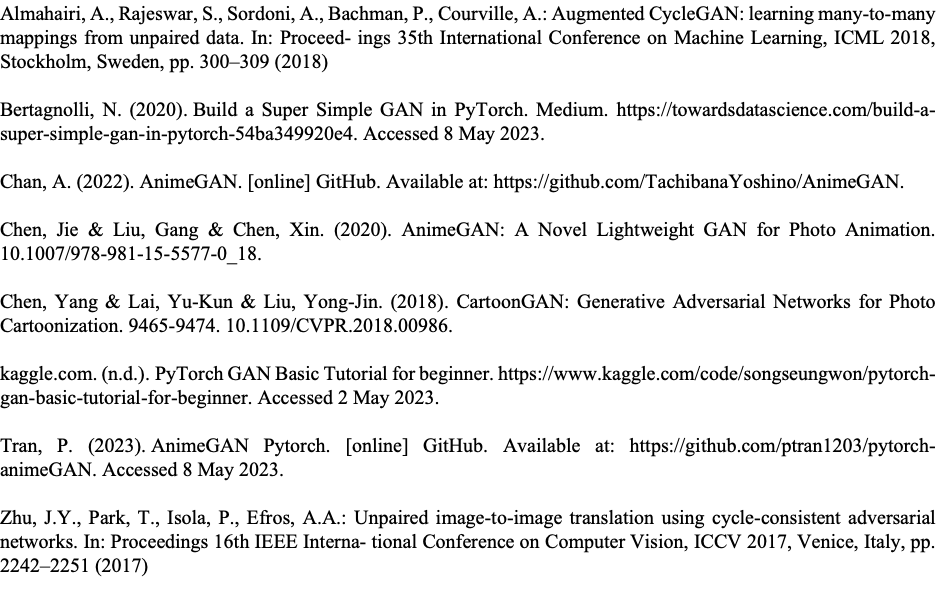